In [1]:
import pandas as pd 
import numpy as np 
from datetime import datetime 
import matplotlib.pyplot as plt
import yfinance as yf 
from curl_cffi import requests
import seaborn as sns 
from pmdarima import auto_arima 
from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa.seasonal import seasonal_decompose
from tabulate import tabulate
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
indices = ['^GSPC', '^NDX', '^DJI', '^FCHI', '^GDAXI', '^NSEI', '^BSESN', '^STI']
start = '2014-01-01'
end = '2024-12-31'
indices_name_map = {'^GSPC' : 'S&P 500',
                    '^DJI'  : 'Dow Jones Industrial Average', 
                    '^NDX'  : 'Nasdaq 100',
                    '^FCHI' : 'CAC40', 
                    '^GDAXI': 'DAX', 
                    '^NSEI' : 'Nifty', 
                    '^BSESN': 'Sensex', 
                    '^STI'  : 'Straits Times Index'}

In [3]:
df = yf.download(indices, start=start, end=end, auto_adjust=False)

[*********************100%***********************]  8 of 8 completed


In [4]:
open = df['Open']
close = df['Close']
adj_close = df['Adj Close']
volume = df['Volume']

In [5]:
intraday_returns = close/open - 1
overnight_returns = open/close.shift(1) - 1
total_returns = close/close.shift(1) - 1 
cum_intraday_returns = intraday_returns.cumsum()
cum_overnight_returns = overnight_returns.cumsum()

### Performance of Indices

In [7]:
adj_close.pct_change().cumsum().loc['2024-12-30']

Ticker
^BSESN    1.454508
^DJI      1.111658
^FCHI     0.740132
^GDAXI    0.950494
^GSPC     1.336632
^NDX      2.036710
^NSEI     1.479346
^STI      0.270894
Name: 2024-12-30 00:00:00, dtype: float64

In [8]:
volume.mean()/10000000

Ticker
^BSESN      0.013092
^DJI       28.017656
^FCHI       8.841161
^GDAXI      8.462555
^GSPC     394.794797
^NDX      335.705937
^NSEI       0.030765
^STI       24.709273
dtype: float64

### Basic plots of intraday vs. overnight returns 

In [9]:
print(f'''Correlation of Intraday returns and Overnight returns for each Index''')
for c in intraday_returns.columns:
    intraday_returns[c].corr(overnight_returns[c])
    print(f'''{indices_name_map[c]}: {np.round(intraday_returns[c].corr(overnight_returns[c]), 2)}''')

Correlation of Intraday returns and Overnight returns for each Index
Sensex: -0.02
Dow Jones Industrial Average: 0.27
CAC40: 0.06
DAX: 0.03
S&P 500: 0.27
Nasdaq 100: 0.02
Nifty: -0.05
Straits Times Index: 0.08


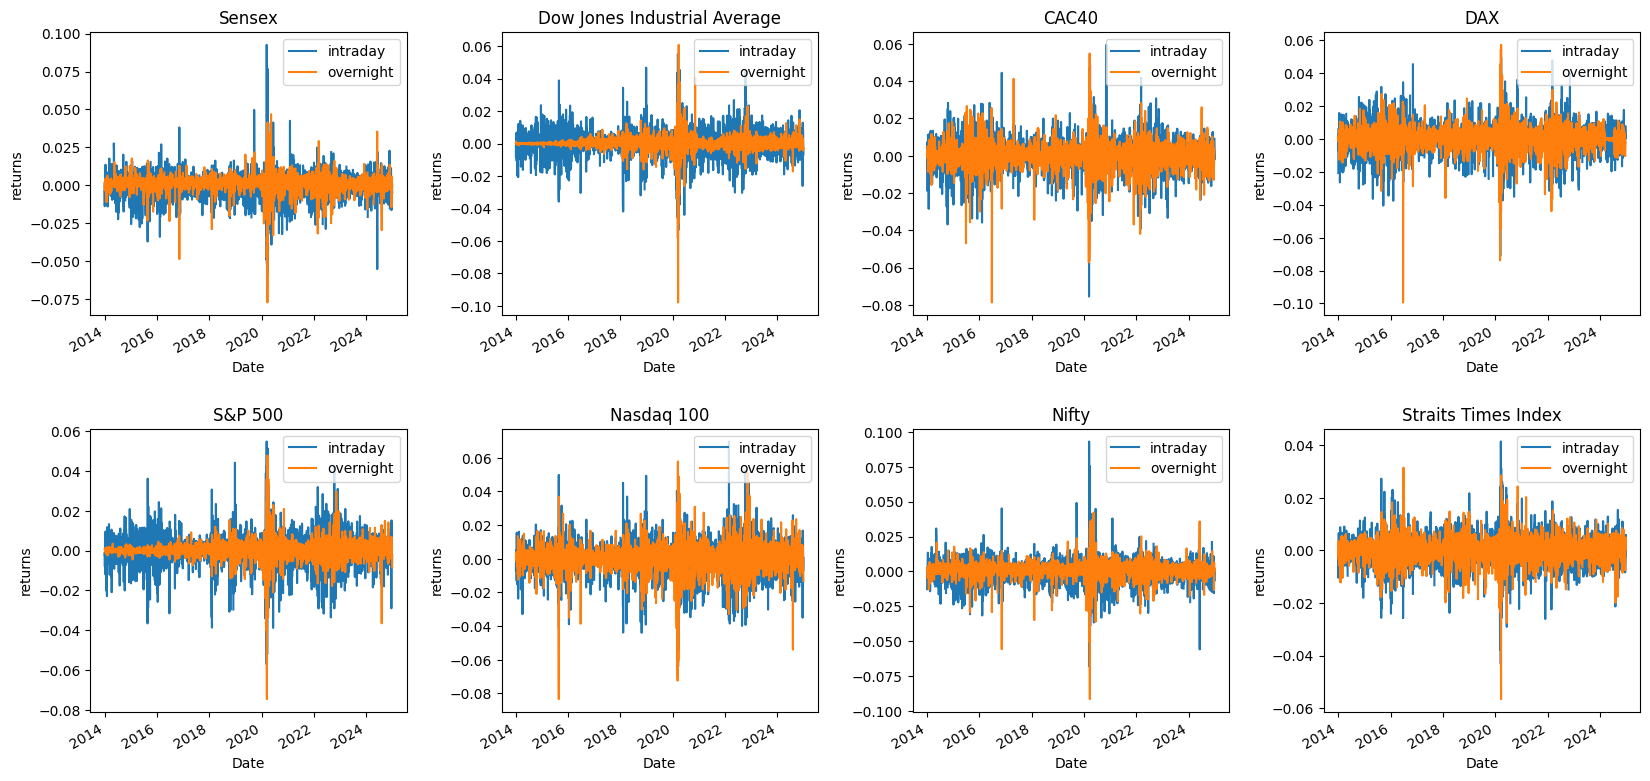

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

row, col = 0, 0
for idx, c in enumerate(intraday_returns.columns):
    ax = pd.DataFrame({'intraday': intraday_returns[c], 'overnight': overnight_returns[c]}).plot(kind='line', ax=axes[row][col], title=indices_name_map[c], ylabel='returns')
    if col == 3:
        row += 1
        col = 0 
    else:
        col += 1
    ax.legend(loc="upper right")
plt.show()

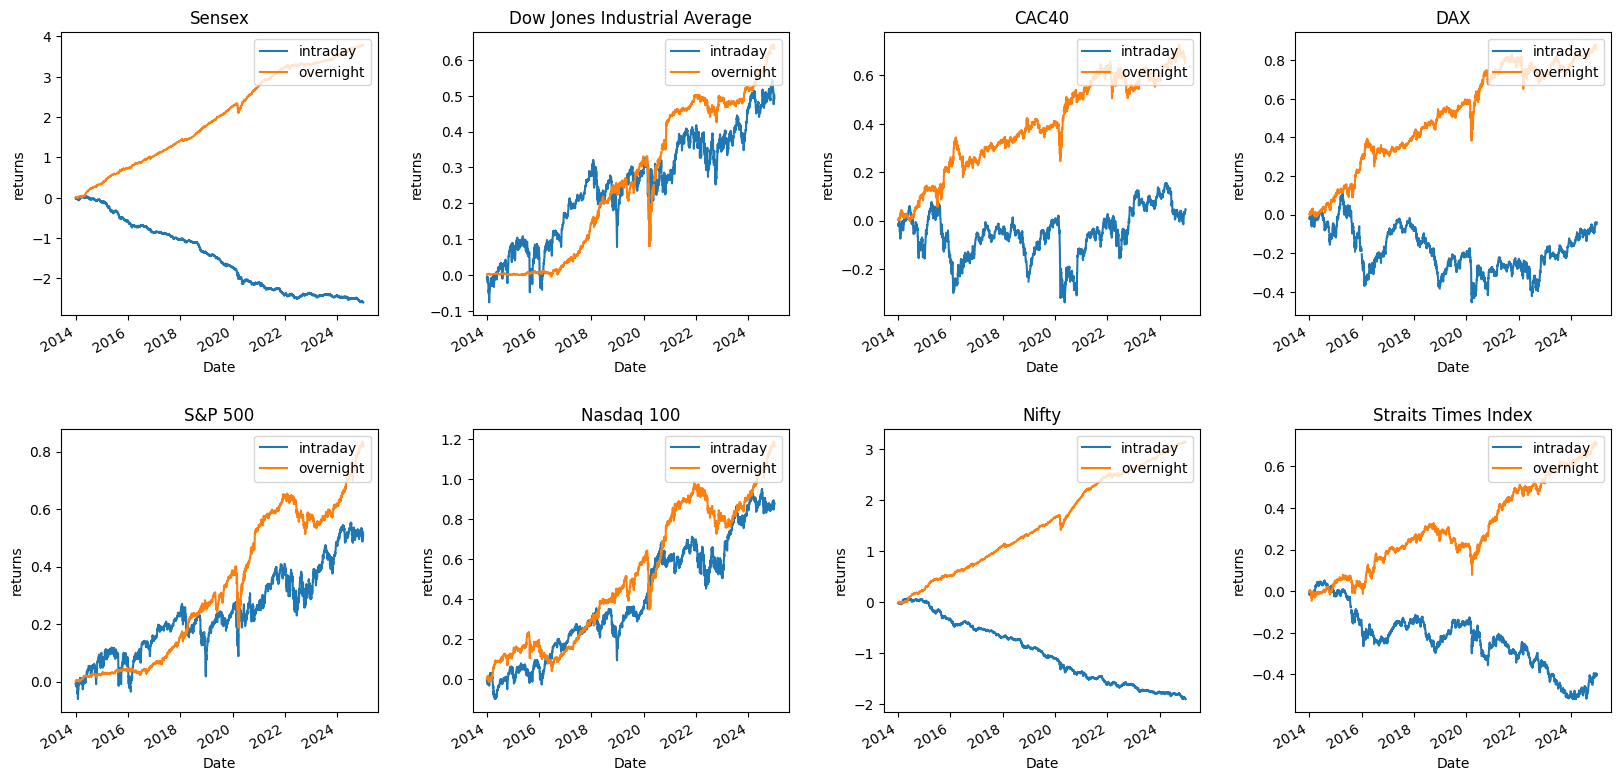

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

row, col = 0, 0
for idx, c in enumerate(cum_intraday_returns.columns):
    ax = pd.DataFrame({'intraday': cum_intraday_returns[c], 'overnight': cum_overnight_returns[c]}).plot(kind='line', ax=axes[row][col], title=indices_name_map[c], ylabel='returns')
    if col == 3:
        row += 1
        col = 0 
    else:
        col += 1
    ax.legend(loc="upper right")
plt.show()

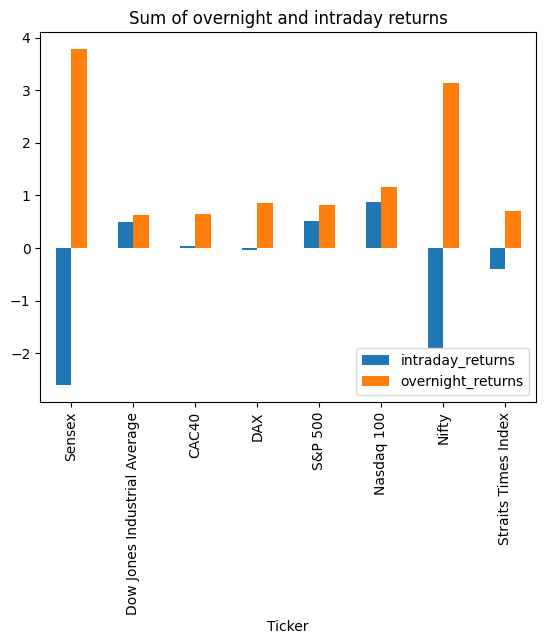

In [12]:
ax = pd.concat([intraday_returns.sum(), overnight_returns.sum()], axis=1).rename({0: 'intraday_returns', 1: 'overnight_returns'}, axis=1).plot(kind='bar', title='Sum of overnight and intraday returns')
labels=[indices_name_map[val] for val in intraday_returns.columns ]
ax.set_xticklabels(labels)
plt.show()

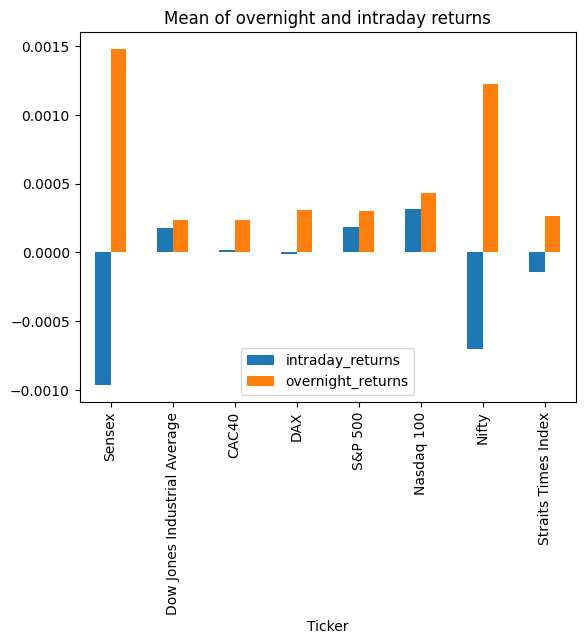

In [13]:
ax = pd.concat([intraday_returns.mean(), overnight_returns.mean()], axis=1).rename({0: 'intraday_returns', 1: 'overnight_returns'}, axis=1).plot(kind='bar', title='Mean of overnight and intraday returns')
labels=[indices_name_map[val] for val in intraday_returns.columns ]
ax.set_xticklabels(labels)
plt.show()

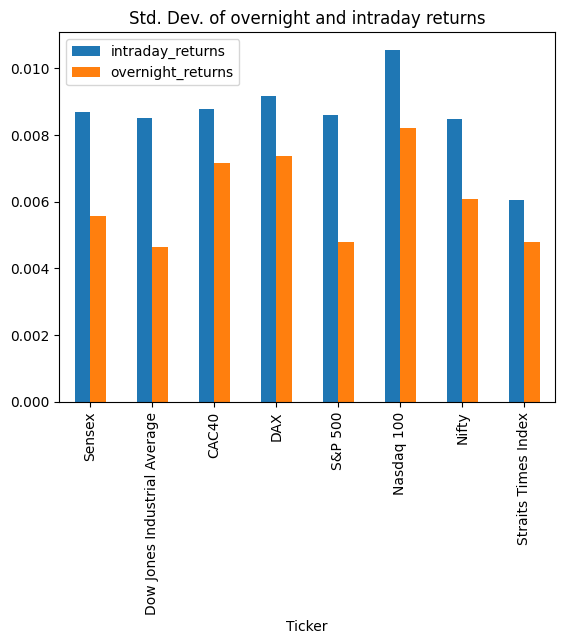

In [14]:
ax = pd.concat([intraday_returns.std(), overnight_returns.std()], axis=1).rename({0: 'intraday_returns', 1: 'overnight_returns'}, axis=1).plot(kind='bar', title='Std. Dev. of overnight and intraday returns')
labels=[indices_name_map[val] for val in intraday_returns.columns ]
ax.set_xticklabels(labels)
plt.show()

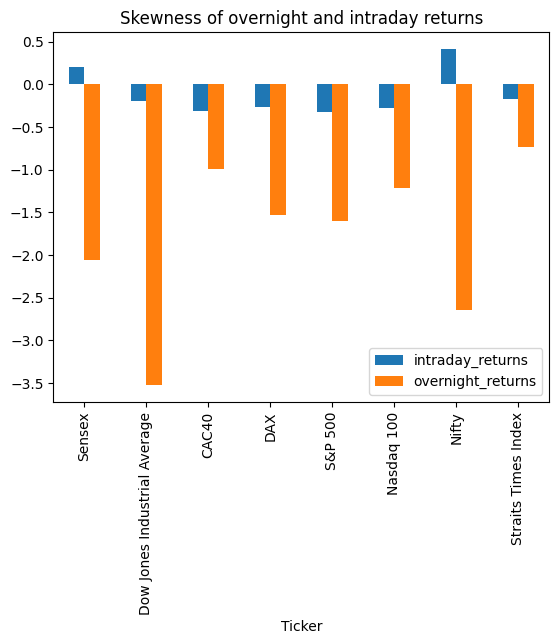

In [15]:
ax = pd.concat([intraday_returns.skew(), overnight_returns.skew()], axis=1).rename({0: 'intraday_returns', 1: 'overnight_returns'}, axis=1).plot(kind='bar', title='Skewness of overnight and intraday returns')
labels=[indices_name_map[val] for val in intraday_returns.columns ]
ax.set_xticklabels(labels)
plt.show()

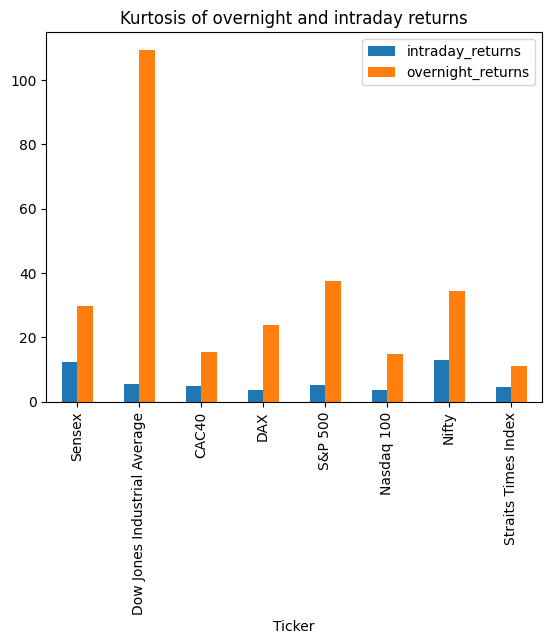

In [16]:
ax = pd.concat([intraday_returns.kurt(), overnight_returns.kurt()], axis=1).rename({0: 'intraday_returns', 1: 'overnight_returns'}, axis=1).plot(kind='bar', title='Kurtosis of overnight and intraday returns')
labels=[indices_name_map[val] for val in intraday_returns.columns ]
ax.set_xticklabels(labels)
plt.show()

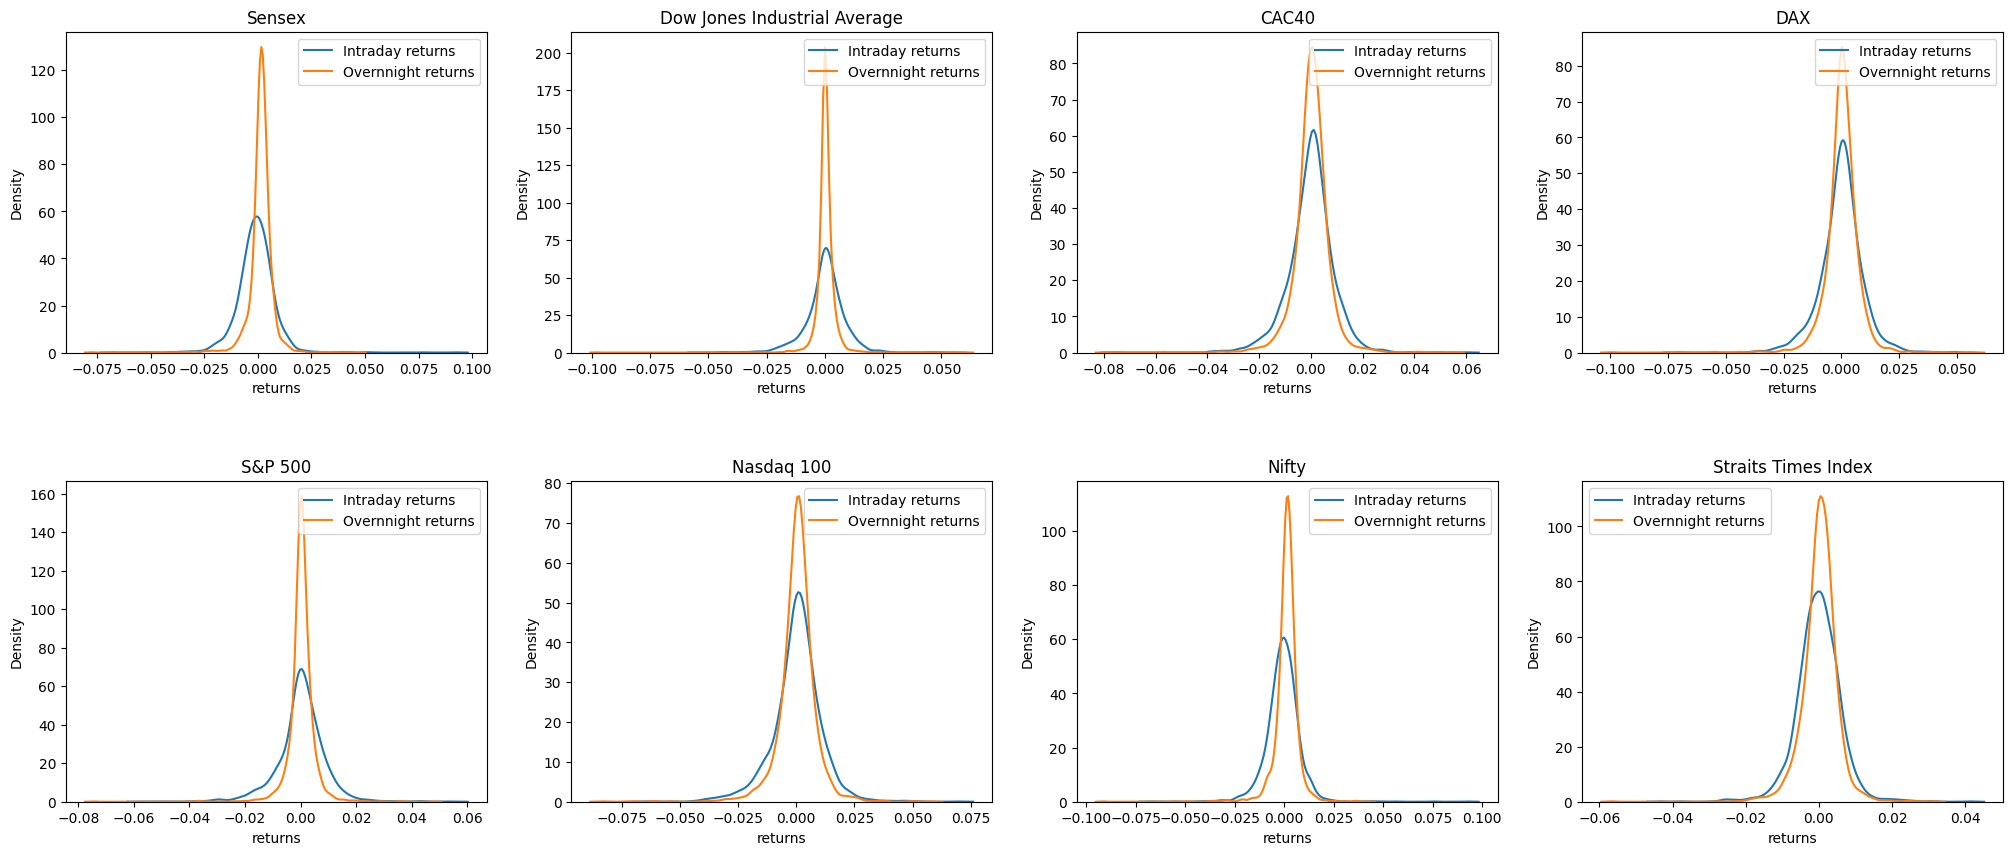

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(25, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

row, col = 0, 0
for idx, c in enumerate(intraday_returns.columns):
    df = pd.DataFrame({'intraday': intraday_returns[c], 'overnight': overnight_returns[c]})
    sns.kdeplot(data=df, x='intraday', ax=axes[row][col], label='Intraday returns')
    ax = sns.kdeplot(data=df, x='overnight', ax=axes[row][col], label='Overnnight returns')
    ax.set_xlabel('returns')
    ax.legend(loc='upper right')
    ax.set_title(f'''{indices_name_map[c]}''')
    if col == 3:
        row += 1
        col = 0
    else:
        col += 1
    ax.legend(loc='upper right')
plt.legend()
plt.show()

### Overnight effect vs. Intraday effect 

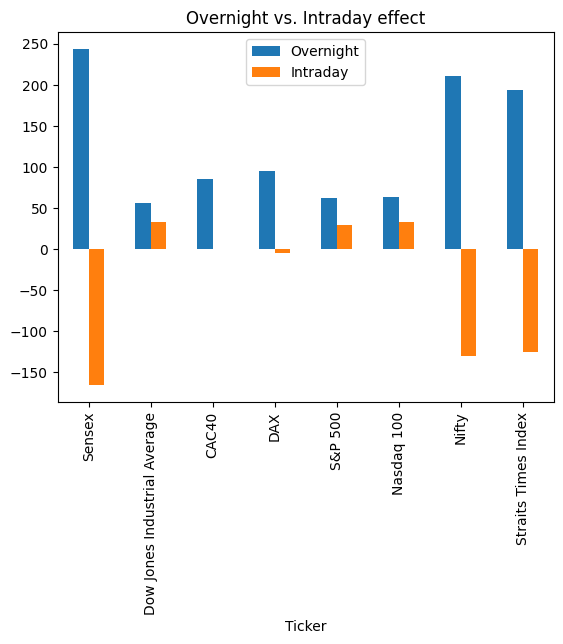

         Overnight    Intraday
Ticker                        
^BSESN  243.696783 -165.182328
^DJI     55.596629   33.499355
^FCHI    85.678343    0.235314
^GDAXI   95.692169   -4.938229
^GSPC    61.835139   29.691918
^NDX     63.504575   32.752107
^NSEI   210.926373 -130.386413
^STI    193.151538 -125.210364


In [18]:
overnight = open - close.shift(1)
intraday = close - open
total = close - close.shift(1)
overnight_change, intraday_change, total_change = overnight.sum(), intraday.sum(), total.sum()
effects = pd.DataFrame(columns=['Overnight', 'Intraday'])
effects['Overnight'] = overnight_change * 100 / total_change 
effects['Intraday'] = intraday_change * 100 / total_change 
ax = effects.plot(title='Overnight vs. Intraday effect', kind='bar')
labels=[indices_name_map[val] for val in open.columns ]
ax.set_xticklabels(labels)
ax.legend(loc='upper center')
plt.show()
print(effects)

### Divide the overnight returns into deciles and find the average overnight and intraday return per decile. Then, divide the overnight return by intraday return to find the proportion by which they differ. 

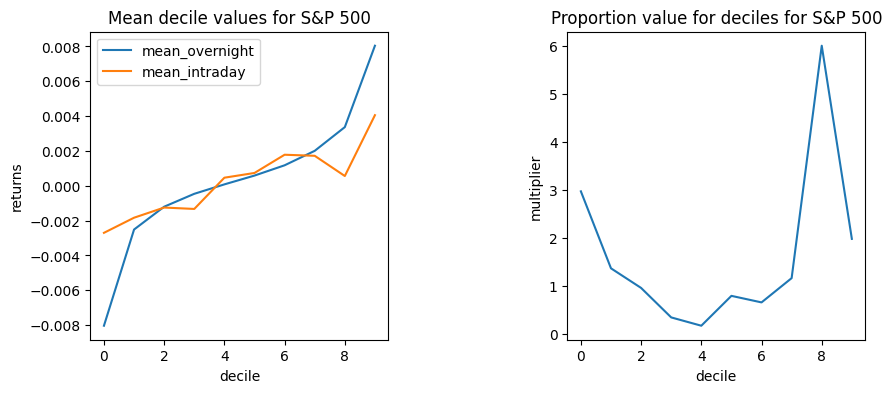

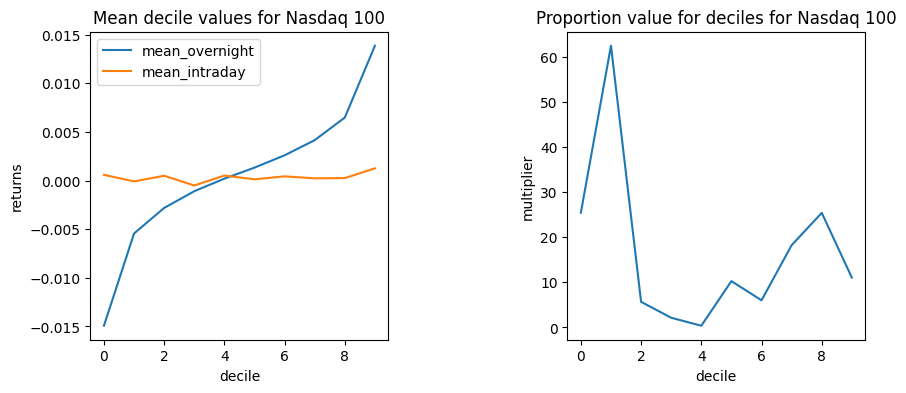

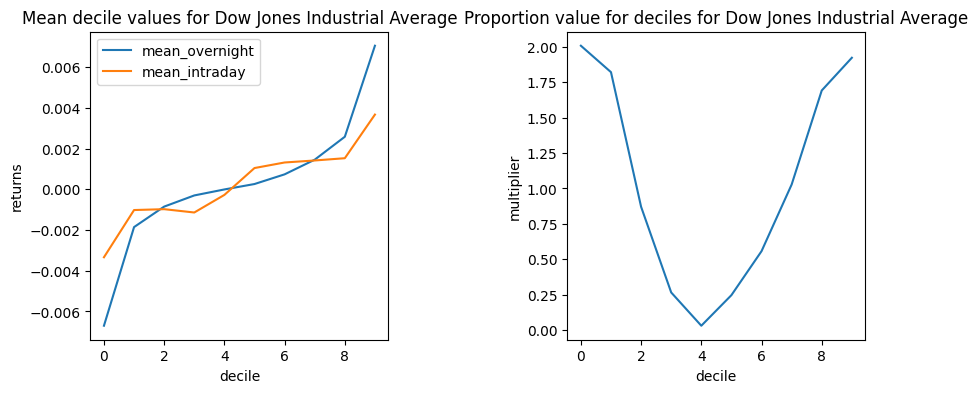

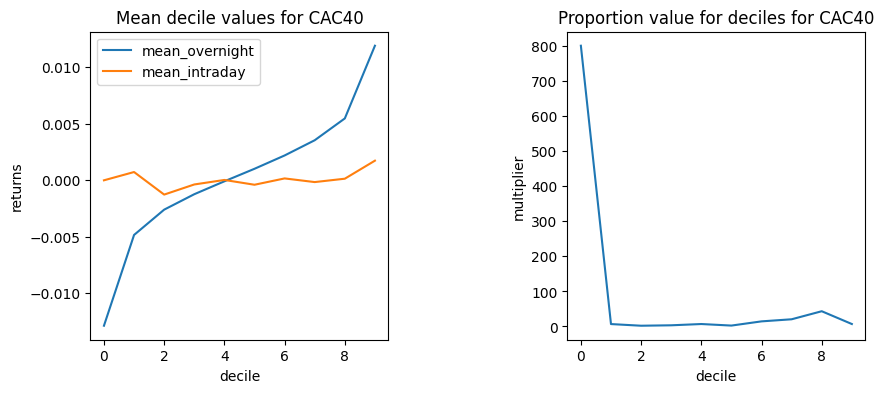

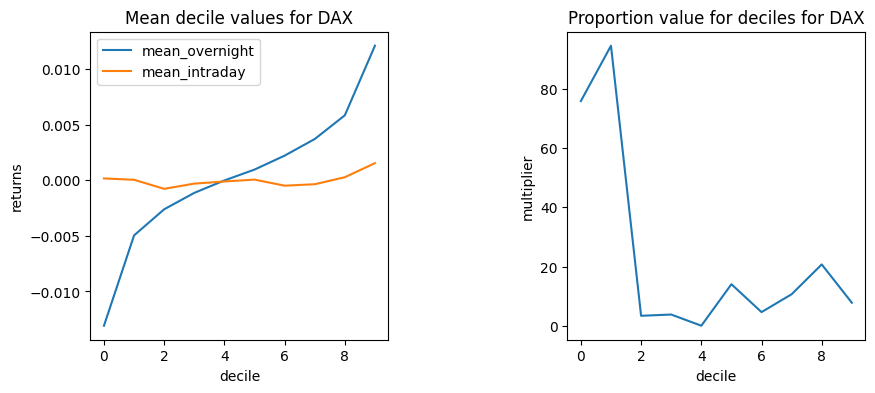

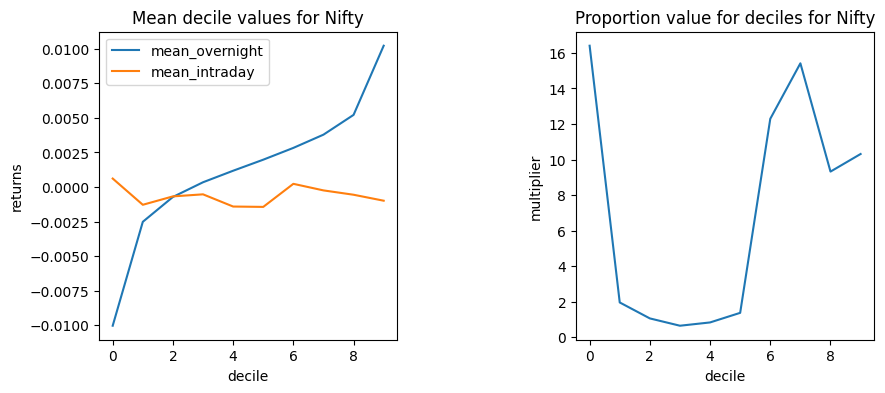

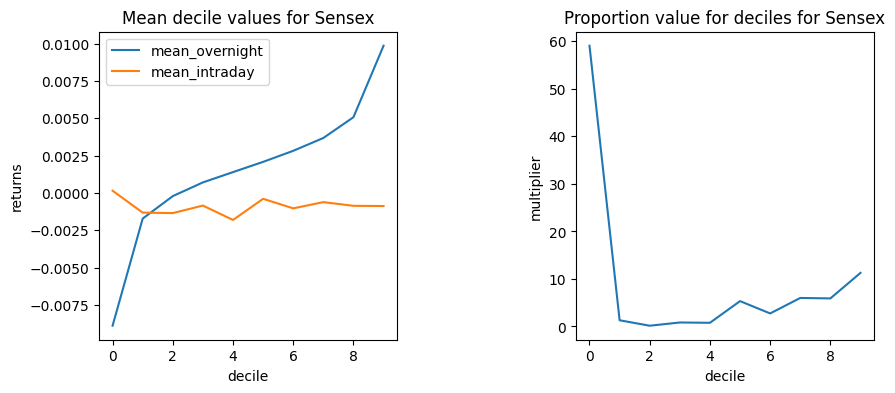

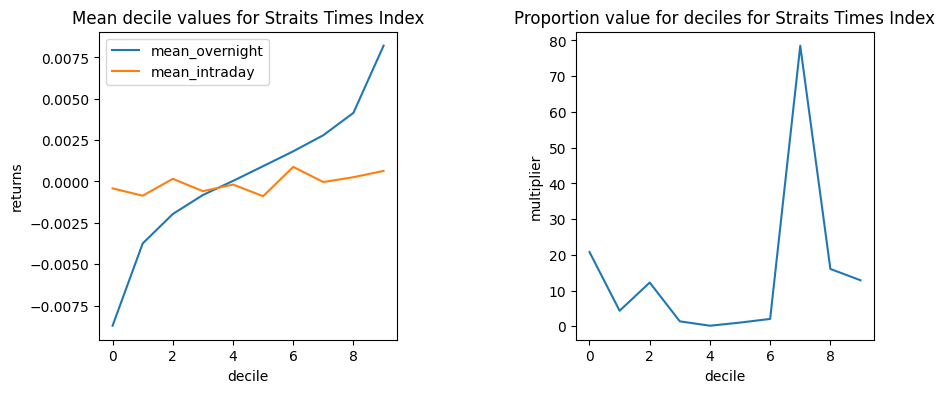

In [19]:
for idx in indices:
    df = pd.DataFrame(columns=['intraday', 'overnight'])
    df['intraday'] = intraday_returns[idx]
    df['overnight'] = overnight_returns[idx]
    df['decile'] = pd.qcut(df['overnight'], q=10, labels=False)
    means = df.groupby(['decile']).agg(mean_overnight=('overnight', 'mean'), mean_intraday=('intraday', 'mean'))
    means['prop'] = (means['mean_overnight']/means['mean_intraday']).abs()
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(hspace=0.3, wspace=0.6)
    means[['mean_overnight', 'mean_intraday']].plot(ax=axes[0], title=f'''Mean decile values for {indices_name_map[idx]}''', ylabel='returns')
    means['prop'].plot(ax=axes[1], title=f'''Proportion value for deciles for {indices_name_map[idx]}''', ylabel='multiplier')
    plt.savefig(f'''overnight_vs_intraday_proportion_{idx}.jpeg''')
    plt.show()
    

### Resample series for index by week and calculate weekly mean returns for week w0, w1, w2, w3, w4 and w5. Divide w0 into deciles and calculate averages per decile for each weekly return. Divide the extremes of each weekly return and find proportion. 

In [20]:
final = pd.DataFrame(index=['multiplier_w0', 'multiplier_w1', 'multiplier_w2', 'multiplier_w3', 'multiplier_w4', 'multiplier_w5'])
for idx in indices:
    df = pd.DataFrame(columns=['intraday', 'overnight'])
    df['intraday'] = intraday_returns[idx]
    df['overnight'] = overnight_returns[idx]
    df.index = intraday_returns.index 
    weekly_returns = df.resample('W').mean()*5
    weekly_overnight_returns = weekly_returns['overnight'].copy().to_frame().rename({'overnight': 'w0'}, axis=1) 
    weekly_overnight_returns['w1'] = weekly_overnight_returns['w0'].shift(-1)
    weekly_overnight_returns['w2'] = weekly_overnight_returns['w0'].shift(-2)
    weekly_overnight_returns['w3'] = weekly_overnight_returns['w0'].shift(-3)
    weekly_overnight_returns['w4'] = weekly_overnight_returns['w0'].shift(-4)
    weekly_overnight_returns['w5'] = weekly_overnight_returns['w0'].shift(-5)
    weekly_overnight_returns['decile'] = pd.qcut(weekly_overnight_returns['w0'], q=10, labels=False)
    weekly_decile_overnight_returns = weekly_overnight_returns.groupby(['decile']).agg(mean_w0=('w0', 'mean'),
                                                                                       mean_w1=('w1', 'mean'), 
                                                                                       mean_w2=('w2', 'mean'),
                                                                                       mean_w3=('w3', 'mean'),
                                                                                       mean_w4=('w4', 'mean'),
                                                                                       mean_w5=('w5', 'mean'))
    extremes = {}
    for c in weekly_decile_overnight_returns.columns:
        extremes[c] = weekly_decile_overnight_returns.loc[9, c]/weekly_decile_overnight_returns.loc[0, c]
    final[indices_name_map[idx]] = extremes.values()


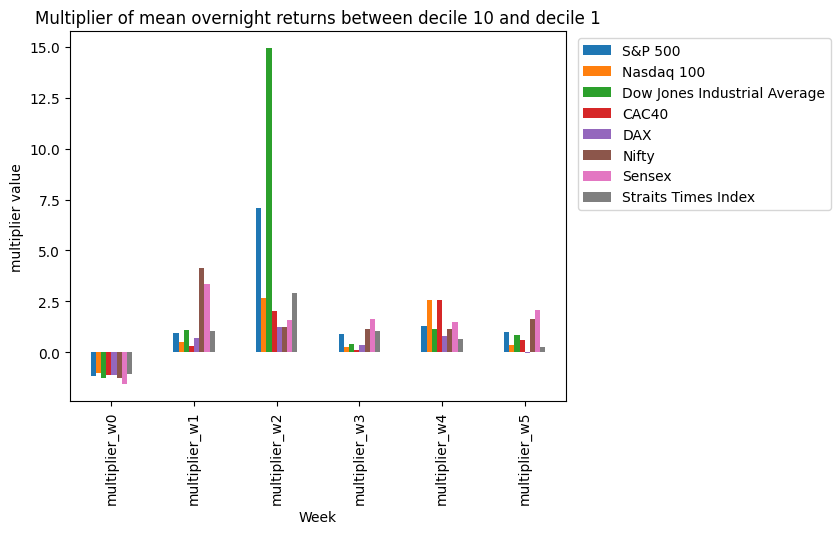

In [22]:
final.plot(kind='bar', title='Multiplier of mean overnight returns between decile 10 and decile 1', xlabel='Week', ylabel='multiplier value')
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.show()

### Simple trading strategy based on quartile ( q count is 5 ) of current day w.r.t last 20 days ( Go long on maximum quartile and short on minimum quartile )

Sharpe Ratio of Strategy
-------------------------
S&P 500: 3.97
Nasdaq 100: 4.16
Dow Jones Industrial Average: 3.7
CAC40: 5.31
DAX: 5.17
Nifty: 3.41
Sensex: 2.83
Straits Times Index: 4.84


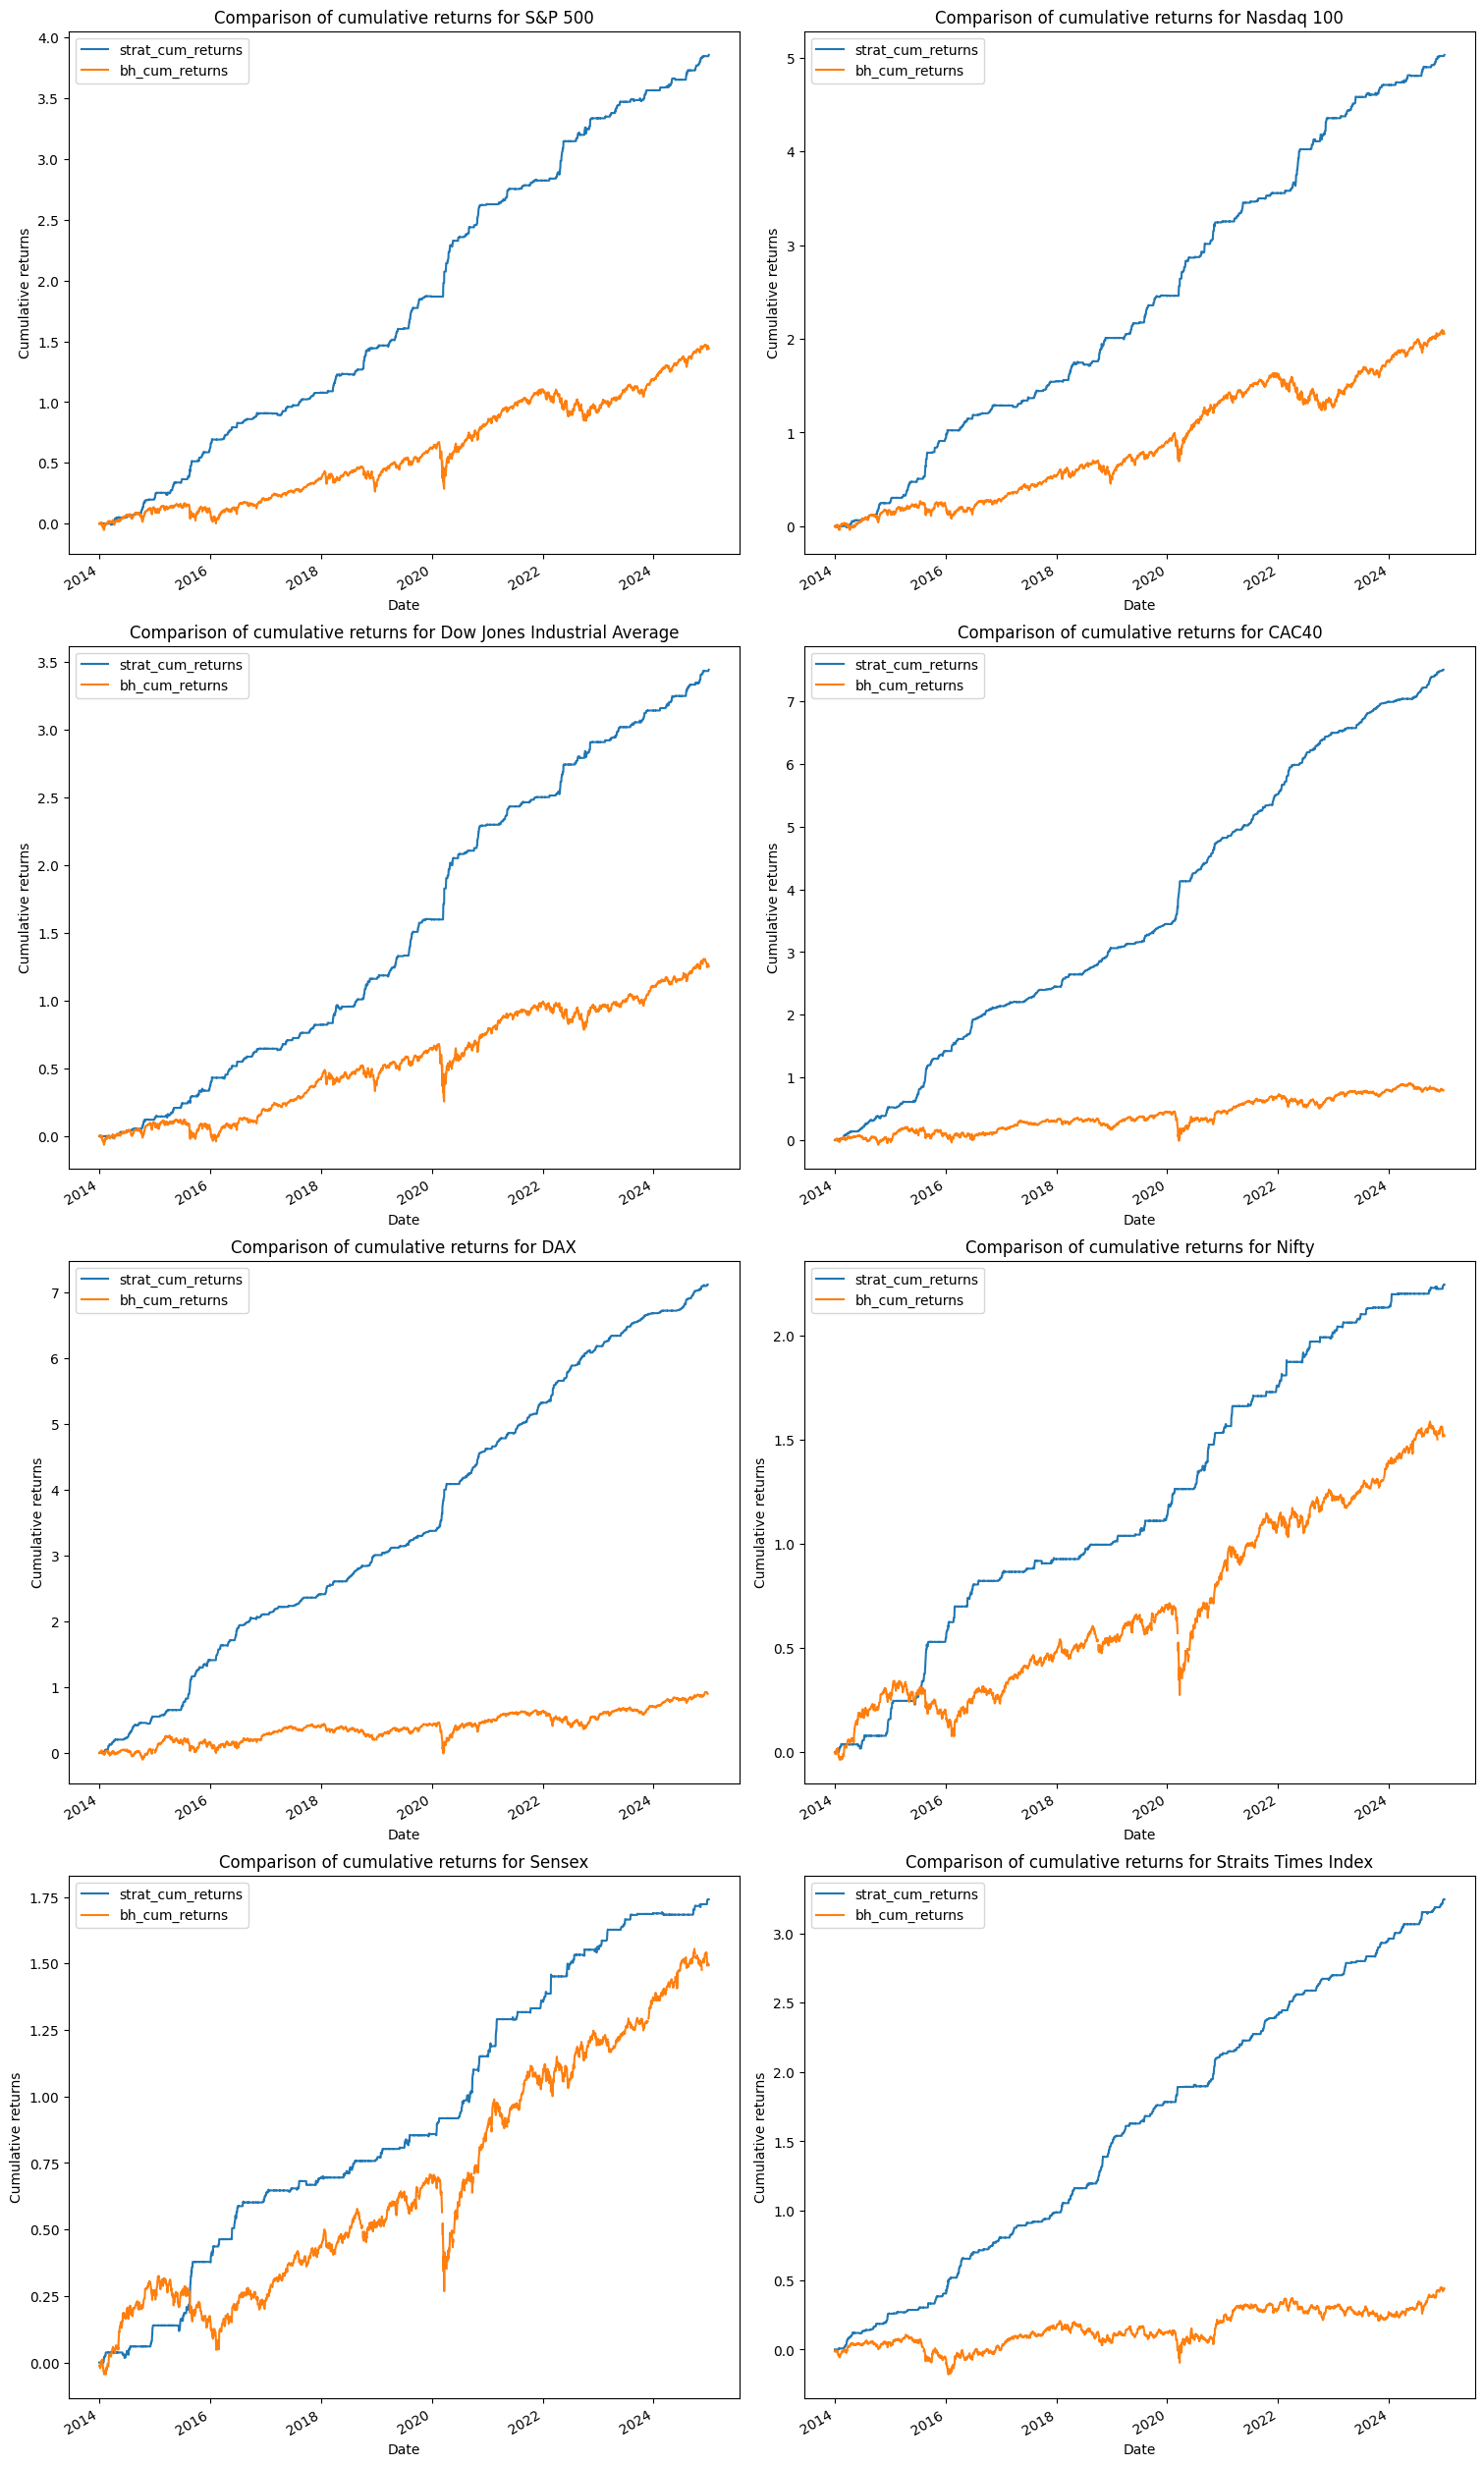

In [23]:
def get_quartile(values):
    s = pd.DataFrame({'values': values})
    s['q'] = pd.qcut(s['values'], q=5, labels=False)
    return s['q'].tolist()[-1]

fig = plt.figure(figsize=(15, 25), layout="constrained")
gs = fig.add_gridspec(4, 2)
plt.subplots_adjust(wspace=0.3)

print("Sharpe Ratio of Strategy")
print("-------------------------")   
row, col = 0, 0
for idx in indices:
    ax = fig.add_subplot(gs[row, col])
    returns = pd.concat([intraday_returns[idx], overnight_returns[idx], total_returns[idx]], axis=1)
    returns.columns = ['intraday', 'overnight', 'total']
    returns['quartile'] = returns['overnight'].rolling(window=20).apply(lambda x: get_quartile(x.tolist()))
    returns['pos'] = 0 
    returns['pos'] = np.where(returns['quartile'] == 0, -1, returns['pos'])
    returns['pos'] = np.where(returns['quartile'] == 4, 1, returns['pos'])
    returns['strat_returns'] = returns['pos']*returns['total']
    returns['bh_cum_returns'] = returns['total'].cumsum()
    returns['strat_cum_returns'] = returns['strat_returns'].cumsum()
    print(f'''{indices_name_map[idx]}: {np.round(returns['strat_returns'].mean()*np.sqrt(252)/returns['strat_returns'].std(), 2)}''')
    returns[['strat_cum_returns', 'bh_cum_returns']].plot(ax=ax, ylabel='Cumulative returns', title=f'''Comparison of cumulative returns for {indices_name_map[idx]}''')
    if col == 1:
        col = 0
        row += 1
    else:
        col += 1
plt.savefig('quartile_strategy_returns.jpeg')
plt.show()

### Categorize the days into different levels as per volatility. Then, for each level of volatility, categorize the days into deciles. Find out the multiplier for returns for each forward week ( w0, w1, w2, w3, w4, w5 ). 

In [24]:
def generate_quartiles(x):
    col_name = x.name
    df = x.to_frame().rename({col_name: 'w0'}, axis=1)
    df['q'] = pd.qcut(df['w0'], q=5, labels=False)
    return df['q'].tolist() 

all_data = pd.DataFrame()

for idx in indices:
    final = pd.DataFrame(index=['multiplier_w0', 'multiplier_w1', 'multiplier_w2', 'multiplier_w3', 'multiplier_w4'])
    df = pd.DataFrame(columns=['overnight'])
    df['overnight'] = overnight_returns[idx]
    df.index = intraday_returns.index 
    weekly_returns = df.resample('W').mean()*5
    weekly_overnight_returns = weekly_returns['overnight'].copy().to_frame().rename({'overnight': 'w0'}, axis=1) 
    weekly_overnight_returns['w1'] = weekly_overnight_returns['w0'].shift(-1)
    weekly_overnight_returns['w2'] = weekly_overnight_returns['w0'].shift(-2)
    weekly_overnight_returns['w3'] = weekly_overnight_returns['w0'].shift(-3)
    weekly_overnight_returns['w4'] = weekly_overnight_returns['w0'].shift(-4)
    weekly_overnight_returns['w5'] = weekly_overnight_returns['w0'].shift(-5)
    weekly_overnight_returns['volatility_8wk'] = weekly_overnight_returns['w0'].rolling(window=8).mean()
    weekly_overnight_returns = weekly_overnight_returns.dropna(axis=0)
    weekly_overnight_returns['volatility_cat'] = pd.qcut(weekly_overnight_returns['volatility_8wk'], q=6, labels=False)
    weekly_overnight_returns['overnight_return_decile'] = weekly_overnight_returns.groupby(['volatility_cat'])['w0'].transform(lambda x: generate_quartiles(x))
    
    weekly_overnight_returns = weekly_overnight_returns.groupby(['volatility_cat', 'overnight_return_decile']).agg(mean_w0=('w0', 'mean'),
                                                                                                                mean_w1=('w1', 'mean'), 
                                                                                                                mean_w2=('w2', 'mean'),
                                                                                                                mean_w3=('w3', 'mean'),
                                                                                                                mean_w4=('w4', 'mean')).reset_index()
    weekly_overnight_returns_multiplier = weekly_overnight_returns.groupby(['volatility_cat']).apply(lambda x: x.iloc[len(x)-1, -6:]/x.iloc[0, -6:])
    cols = [ val.replace('mean', 'multiplier') for val in weekly_overnight_returns_multiplier.columns ]
    weekly_overnight_returns_multiplier.columns = cols
    weekly_overnight_returns_multiplier = weekly_overnight_returns_multiplier.reset_index()
    weekly_overnight_returns_multiplier['index'] = indices_name_map[idx]
    all_data = pd.concat([all_data, weekly_overnight_returns_multiplier]).reset_index(drop=True)
    

In [25]:
columns = ['multiplier_w0', 'multiplier_w1', 'multiplier_w2', 'multiplier_w3', 'multiplier_w4']
all_data = all_data.melt(id_vars=['volatility_cat', 'index'], value_vars=columns).set_index(['volatility_cat', 'index', 'variable']).unstack(level=-2).reset_index()
all_data_cols = ['volatility_cat', 'multiplier'] + list(all_data.columns.get_level_values(1)[2:])
all_data.columns = all_data_cols

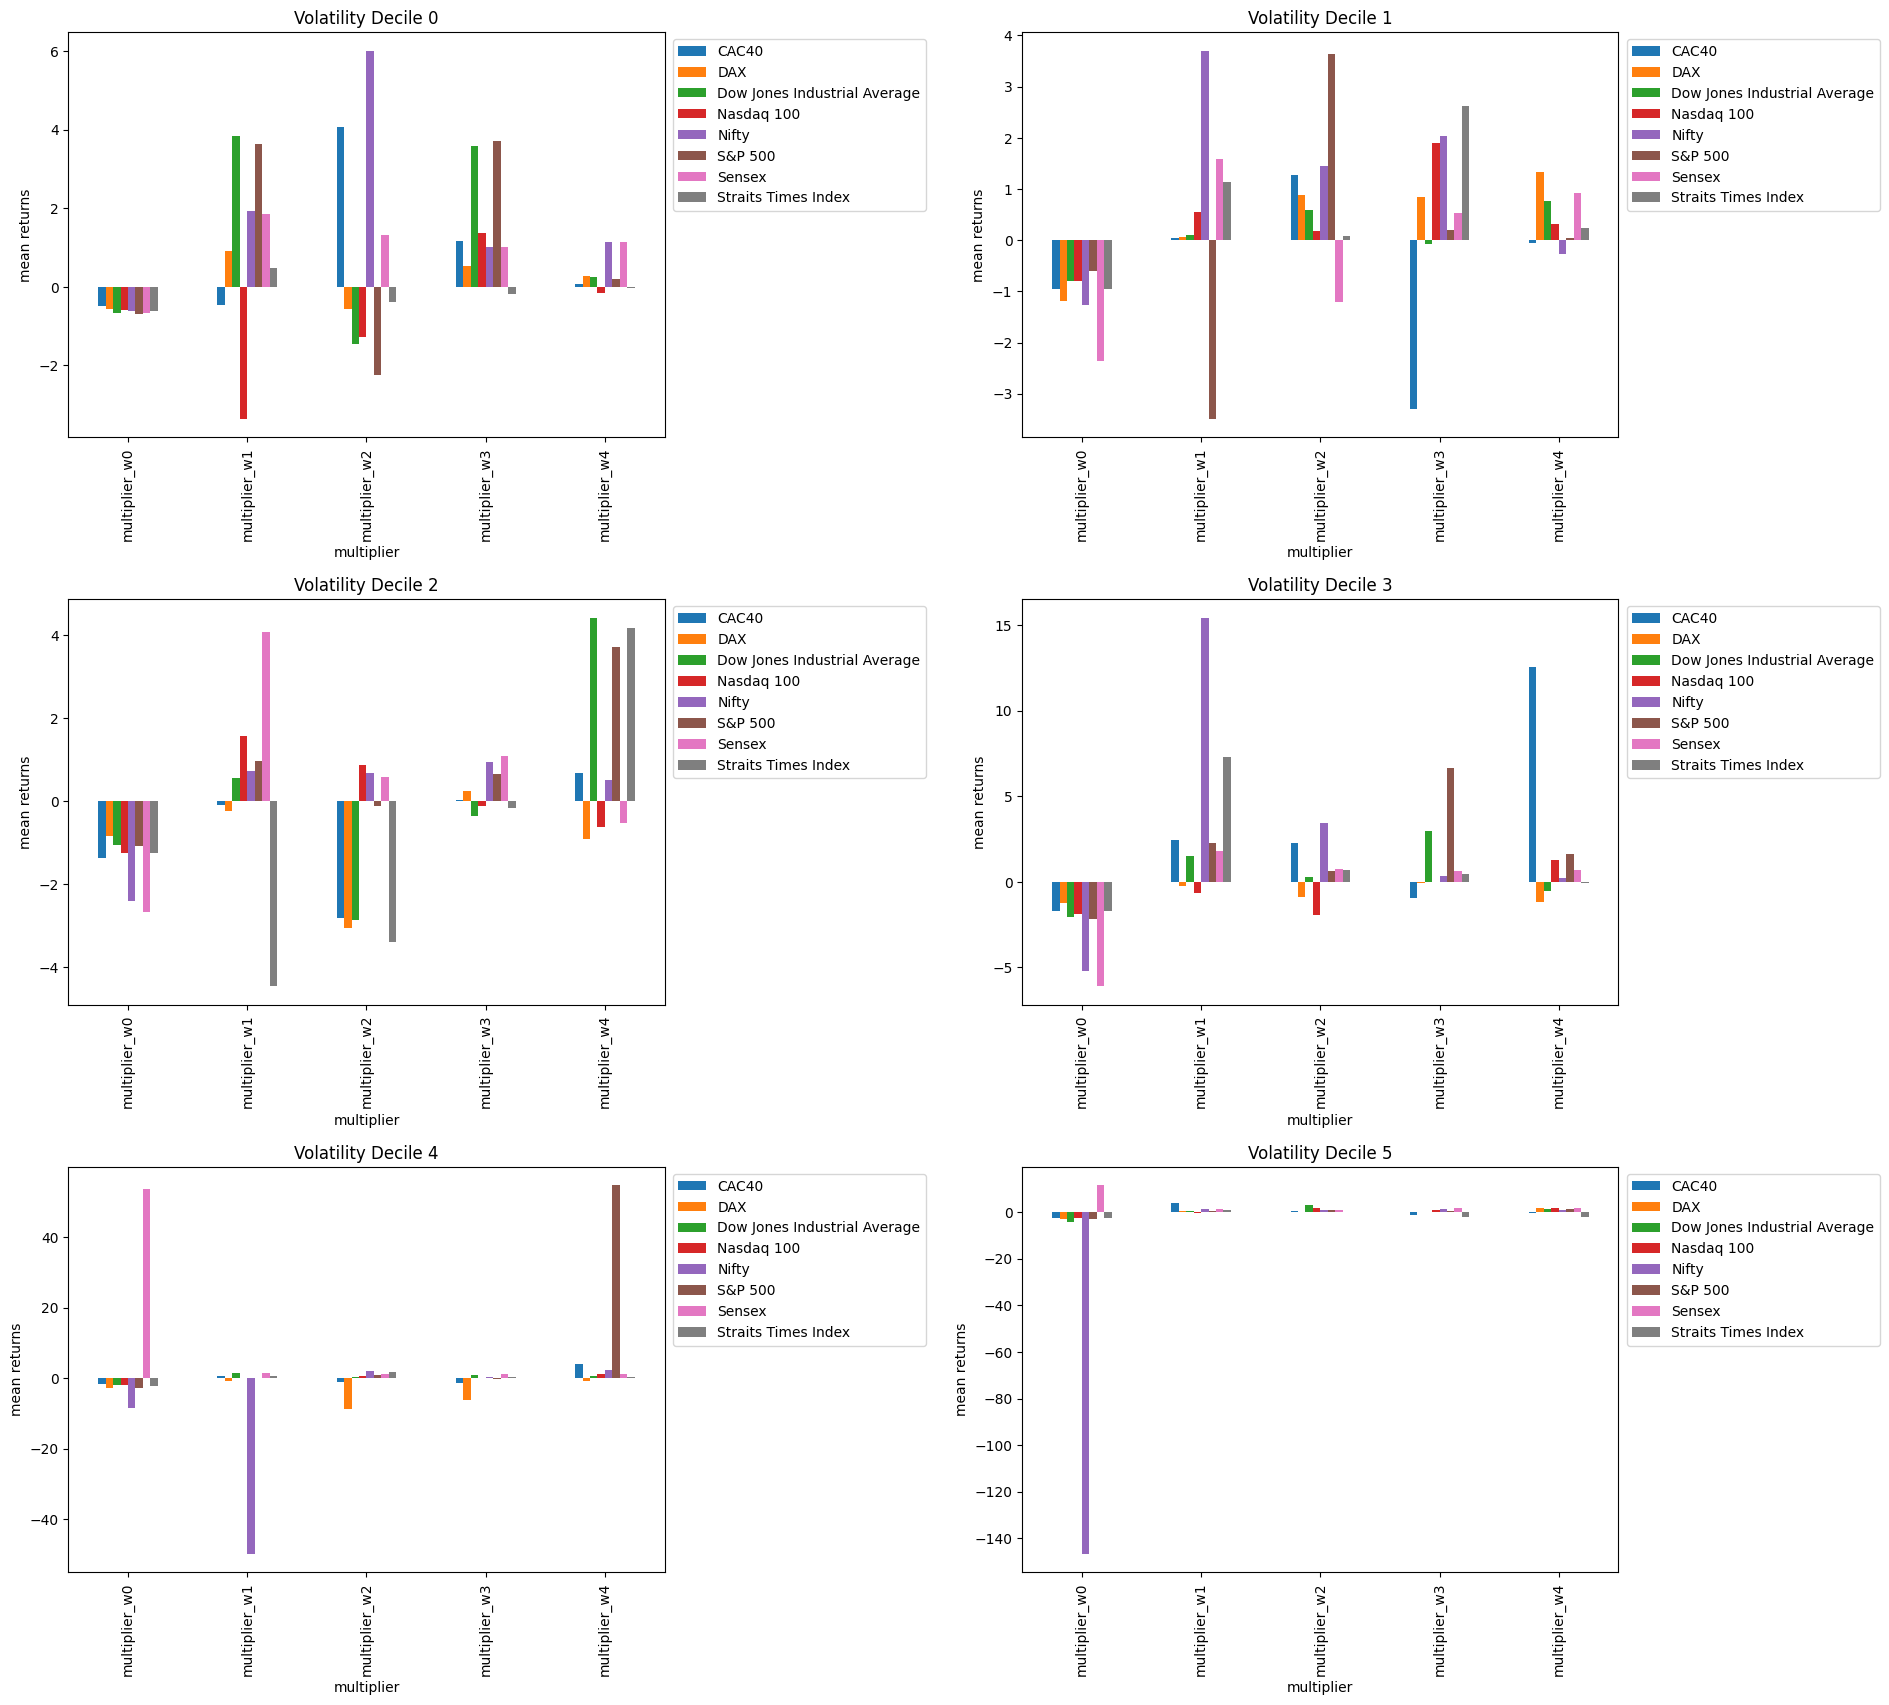

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.6)

row, col = 0, 0
for v_cat in all_data['volatility_cat'].unique():
    df = all_data[all_data['volatility_cat'] == v_cat].reset_index(drop=True)
    ax = df.drop(['volatility_cat'], axis=1).plot(x='multiplier', ax=axes[row][col], kind='bar', title=f'''Volatility Decile {v_cat}''', ylabel='mean returns')
    ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1))   
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1
plt.savefig('volatility_deciles.jpeg')
plt.show()

### Identifying hidden states using HMM 

Model is not converging.  Current: 11268.892810803345 is not greater than 11269.868951937893. Delta is -0.9761411345480155
Model is not converging.  Current: 9032.924700781132 is not greater than 9032.988329711556. Delta is -0.06362893042387441
Model is not converging.  Current: 8169.281357321054 is not greater than 8169.334189751253. Delta is -0.05283243019857764
Model is not converging.  Current: 11776.733125040872 is not greater than 11776.954036138775. Delta is -0.2209110979038087
Model is not converging.  Current: 9700.161884051691 is not greater than 9700.168075534404. Delta is -0.006191482712893048
Model is not converging.  Current: 10352.100438732097 is not greater than 10352.139366871905. Delta is -0.03892813980746723
Model is not converging.  Current: 10116.348731407898 is not greater than 10116.399201604574. Delta is -0.0504701966765424
Model is not converging.  Current: 9369.399725337082 is not greater than 9369.410745579591. Delta is -0.011020242509403033
Model is not conv

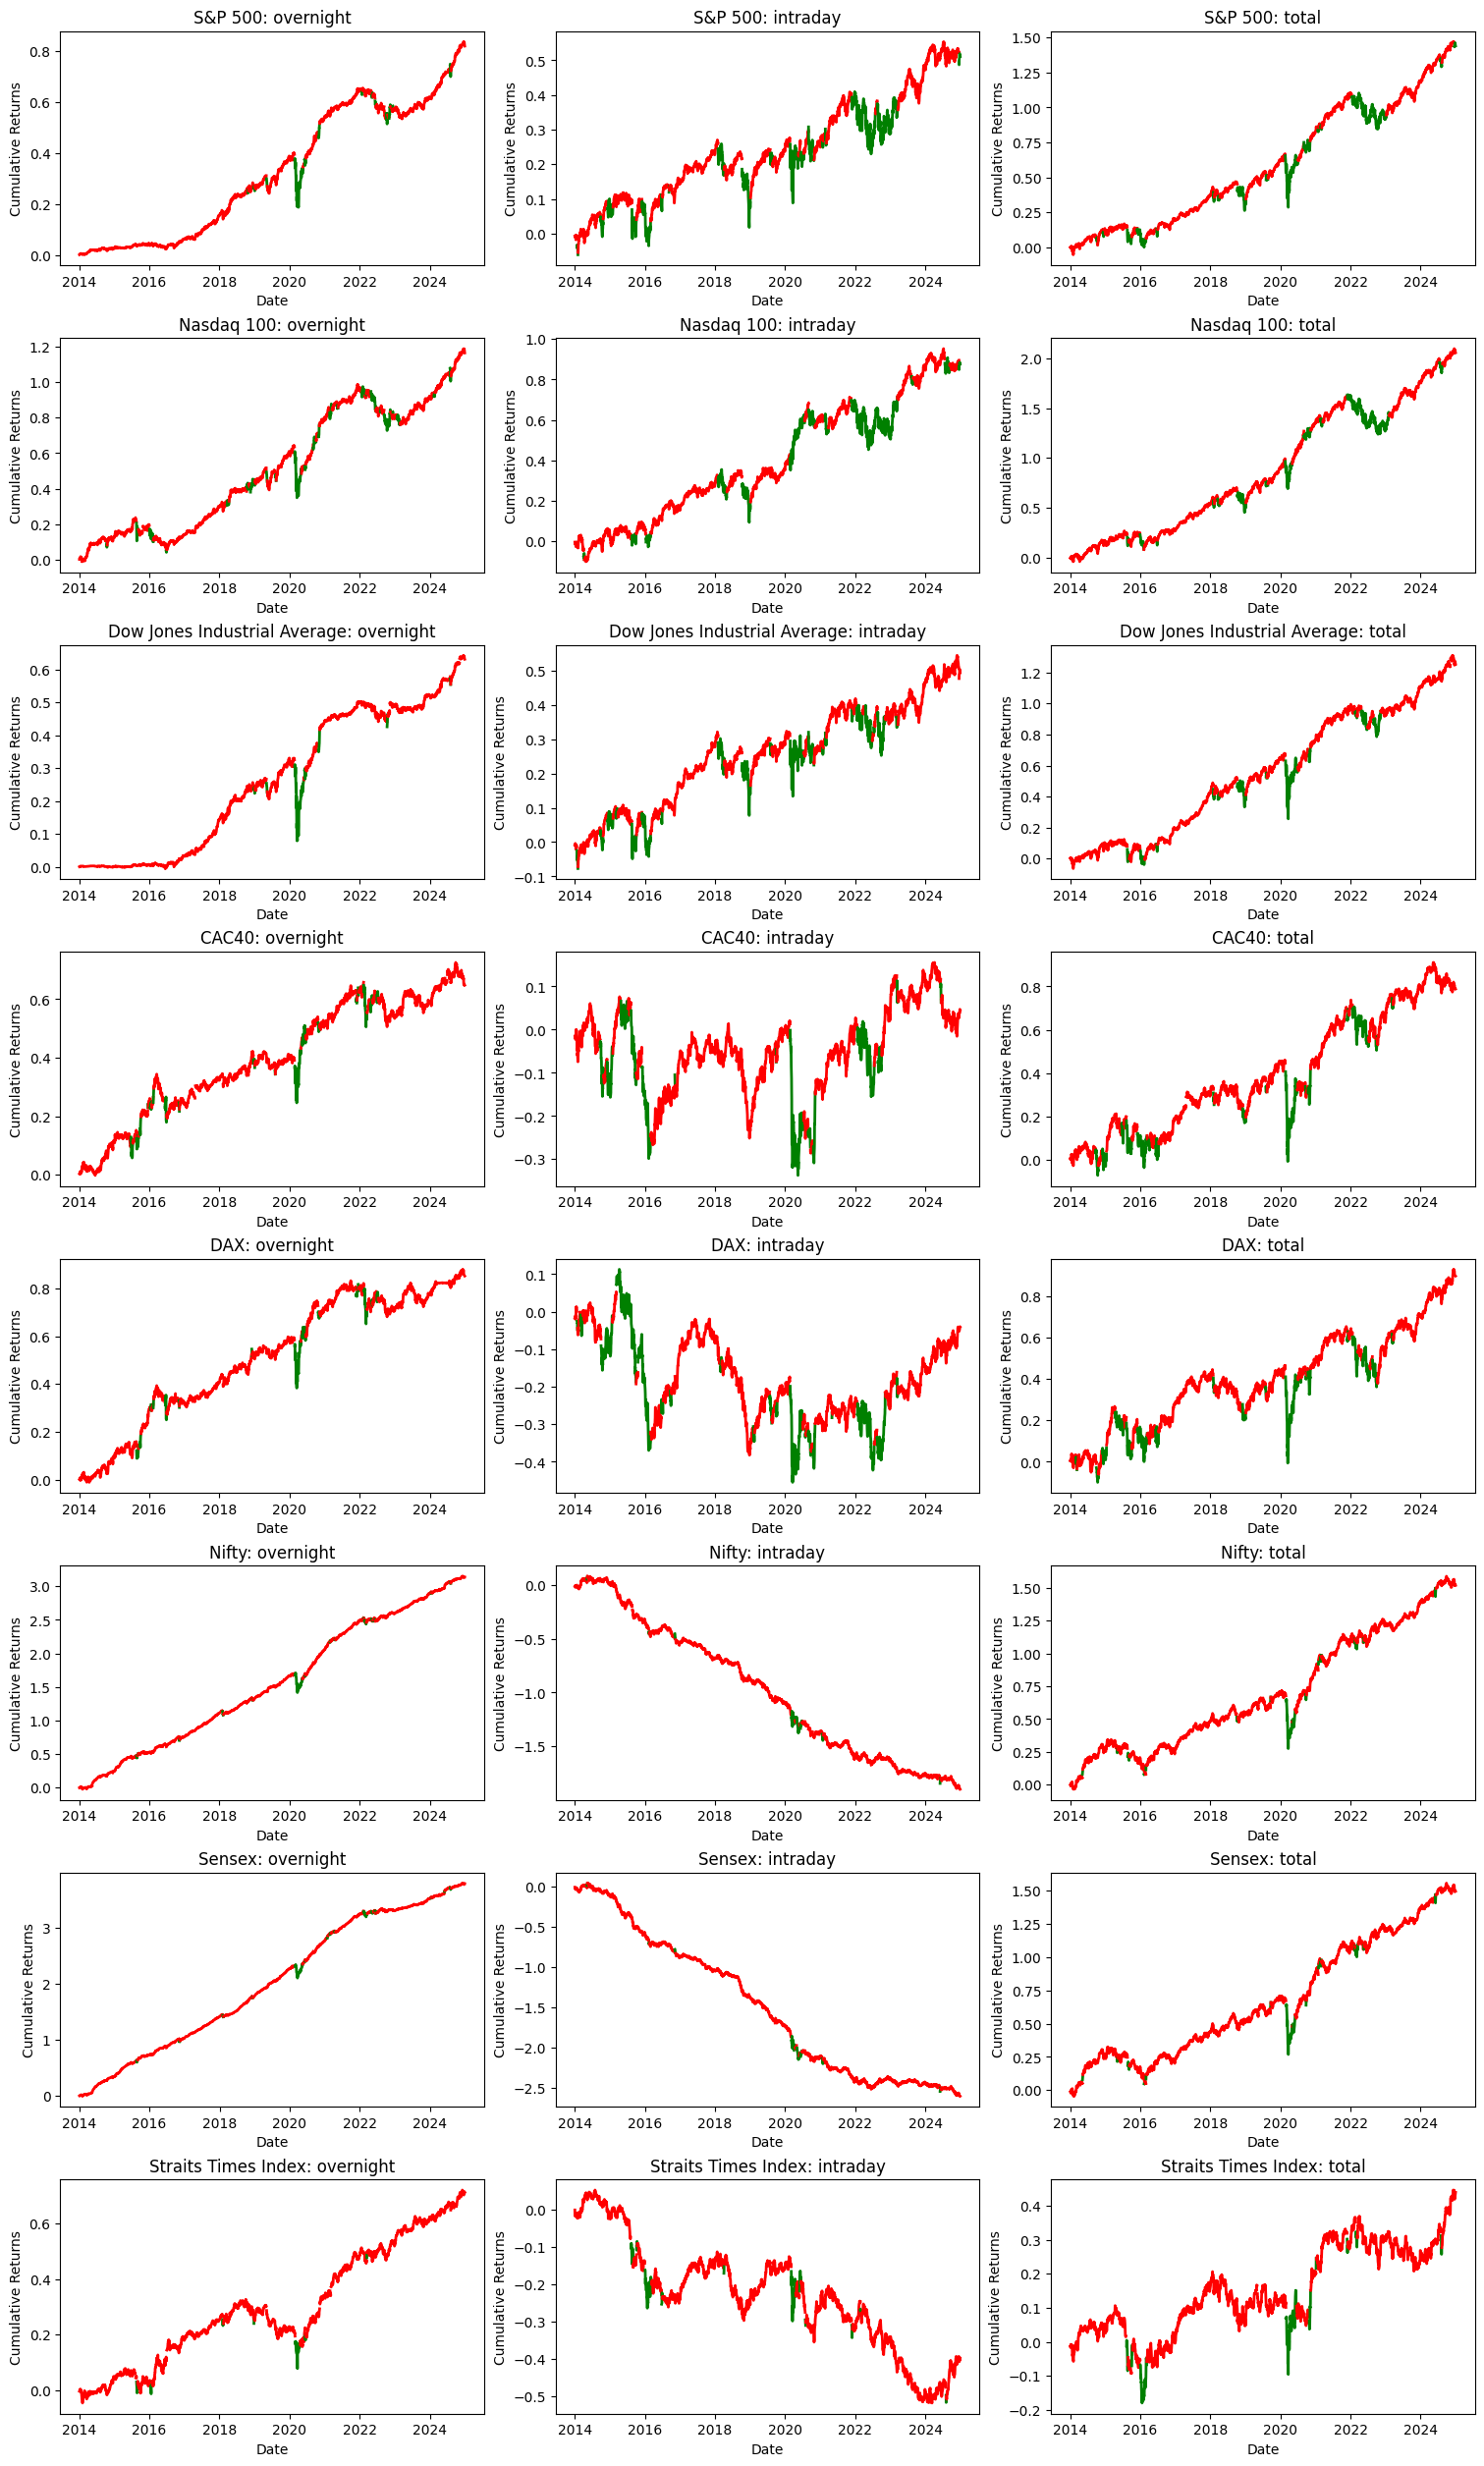

In [38]:
fig = plt.figure(figsize=(15, 25), layout="constrained")
gs = fig.add_gridspec(8, 3)

for row, idx in enumerate(indices):
    df = pd.concat([overnight_returns[idx], intraday_returns[idx], total_returns[idx]], axis=1)
    df.columns = ['overnight', 'intraday', 'total'] 
    df = df.dropna(axis=0, how='all')
    for col, c in enumerate(df.columns):
        returns = df[[c]].dropna(axis=0)
        returns['cum'] = returns[c].cumsum()
        model = GaussianHMM(n_components=2, covariance_type='full', n_iter=500, random_state=42)
        model.fit(returns[c].dropna(axis=0).to_numpy().reshape(-1, 1))
        returns['regimes'] = model.predict(returns[c].to_numpy().reshape(-1, 1))

        returns['diff'] = (returns['regimes'].shift() != returns['regimes']).cumsum()
        ax = fig.add_subplot(gs[row, col])
           
        def plot_func(group):
            global ax
            if (group['regimes'] == 0).all():
                color = 'r'
            else:
                color = 'g'     
            
            lw = 2.0 
            ax.plot(group.index, group.cum, c=color, linewidth=lw)
            ax.set_xlabel('Date')
            ax.set_ylabel('Cumulative Returns')
            ax.set_title(f'''{indices_name_map[idx]}: {c}''')
        returns.groupby(['diff']).apply(plot_func)
plt.savefig('returns_hmm.jpeg')
plt.show()


### Properties of Hidden States of HMM 

In [14]:
def infer_regime(x):
    x = x.to_numpy()
    model = GaussianHMM(n_components=2, covariance_type='full', n_iter=500, random_state=42)
    model.fit(x.reshape(-1, 1))
    return model.predict(x.reshape(-1, 1))

df1 = overnight_returns.transpose().stack().to_frame().rename({0:'overnight'}, axis=1).reset_index()
df2 = intraday_returns.transpose().stack().to_frame().rename({0:'intraday'}, axis=1).reset_index()
df3 = total_returns.transpose().stack().to_frame().rename({0:'total'}, axis=1).reset_index()

df1['Ticker'] = df1['Ticker'].map(indices_name_map)
df2['Ticker'] = df2['Ticker'].map(indices_name_map)
df3['Ticker'] = df3['Ticker'].map(indices_name_map)

df1['regime'] = df1.groupby(['Ticker'])['overnight'].transform(lambda x: infer_regime(x))
df2['regime'] = df2.groupby(['Ticker'])['intraday'].transform(lambda x: infer_regime(x))
df3['regime'] = df3.groupby(['Ticker'])['total'].transform(lambda x: infer_regime(x))
final = pd.concat([df1.groupby(['Ticker', 'regime']).agg(mean_overnight=('overnight', 'mean'), std_overnight=('overnight', 'std')), \
                   df2.groupby(['Ticker', 'regime']).agg(mean_intraday=('intraday', 'mean'), std_intraday=('intraday', 'std')), \
                   df3.groupby(['Ticker', 'regime']).agg(mean_total=('total', 'mean'), std_total=('total', 'std'))], axis=1)
final

Model is not converging.  Current: 10352.100438732097 is not greater than 10352.139366871905. Delta is -0.03892813980746723
Model is not converging.  Current: 10116.348731407898 is not greater than 10116.399201604574. Delta is -0.0504701966765424
Model is not converging.  Current: 11776.733125040872 is not greater than 11776.954036138775. Delta is -0.2209110979038087
Model is not converging.  Current: 10107.268345769711 is not greater than 10107.370020401171. Delta is -0.10167463145990041
Model is not converging.  Current: 11268.892810803345 is not greater than 11269.868951937893. Delta is -0.9761411345480155
Model is not converging.  Current: 10701.913224046733 is not greater than 10702.115782243343. Delta is -0.20255819660997076
Model is not converging.  Current: 9369.399725337082 is not greater than 9369.410745579591. Delta is -0.011020242509403033
Model is not converging.  Current: 9700.161884051691 is not greater than 9700.168075534404. Delta is -0.006191482712893048
Model is not 

mean_overnight  std_overnight  \
Ticker                       regime                                  
CAC40                        0             0.000333       0.004913   
                             1            -0.000893       0.018931   
DAX                          0             0.000409       0.005246   
                             1            -0.001134       0.021212   
Dow Jones Industrial Average 0             0.000256       0.002563   
                             1            -0.000275       0.019582   
Nasdaq 100                   0             0.000723       0.005338   
                             1            -0.001379       0.017540   
Nifty                        0             0.001489       0.003994   
                             1            -0.004480       0.021554   
S&P 500                      0             0.000354       0.003141   
                             1            -0.000558       0.015884   
Sensex                       0             0.001680       0.003539   
                             1            -0.001851       0.018223   
Straits Times Index          0             0.000300       0.004018   
                             1            -0.000983       0.016599   

                                     mean_intraday  std_intraday  mean_total  \
Ticker                       regime                                            
CAC40                        0            0.000374      0.006683    0.000620   
                             1           -0.001581      0.014828   -0.001307   
DAX                          0            0.000279      0.006581    0.000804   
                             1           -0.000856      0.014151   -0.001689   
Dow Jones Industrial Average 0            0.000591      0.005504    0.000751   
                             1           -0.001261      0.014758   -0.001482   
Nasdaq 100                   0            0.000585      0.007092    0.001377   
                             1           -0.000396      0.016558   -0.001532   
Nifty                        0           -0.000643      0.006963    0.000610   
                             1           -0.002632      0.028816    0.000287   
S&P 500                      0            0.000607      0.005309    0.001001   
                             1           -0.000952      0.014021   -0.001064   
Sensex                       0           -0.000865      0.007171    0.000541   
                             1           -0.004423      0.030429    0.001498   
Straits Times Index          0           -0.000041      0.005047    0.000193   
                             1           -0.002272      0.016149   -0.000267   

                                     std_total  
Ticker                       regime             
CAC40                        0        0.008154  
                             1        0.021440  
DAX                          0        0.008439  
                             1        0.020978  
Dow Jones Industrial Average 0        0.007078  
                             1        0.023748  
Nasdaq 100                   0        0.009134  
                             1        0.023504  
Nifty                        0        0.007764  
                             1        0.030363  
S&P 500                      0        0.006650  
                             1        0.019478  
Sensex                       0        0.007827  
                             1        0.031126  
Straits Times Index          0        0.006459  
                             1        0.020014

### Simple HMM trading strategy using overnight returns 

In [15]:
sharpes = pd.DataFrame(columns=['overnight', 'intraday', 'total'])
for idx in indices:
    data = []
    returns = pd.concat([intraday_returns[idx], overnight_returns[idx], total_returns[idx]], axis=1)
    returns.columns = ['intraday', 'overnight', 'total'] 
    returns = returns.dropna(axis=0)
    
    c = 'overnight'
    model = GaussianHMM(n_components=2, covariance_type='full', n_iter=500, random_state=42)
    model.fit(returns[c].dropna(axis=0).to_numpy().reshape(-1, 1))
    returns['regimes'] = model.predict(returns[c].dropna(axis=0).to_numpy().reshape(-1, 1))
    returns['pos'] = np.where(returns['regimes'] == 0, 1, -1)
    returns['strat_ret'] = returns['pos'] * returns['total']
    data.append(np.sqrt(252) * returns['strat_ret'].mean()/returns['strat_ret'].std())
    
    c = 'intraday'
    model = GaussianHMM(n_components=2, covariance_type='full', n_iter=500, random_state=42)
    model.fit(returns[c].dropna(axis=0).to_numpy().reshape(-1, 1))
    returns['regimes'] = model.predict(returns[c].dropna(axis=0).to_numpy().reshape(-1, 1))
    returns['pos'] = np.where(returns['regimes'] == 0, 1, -1)
    returns['pos'] = returns['pos'].shift(1)
    returns['strat_ret'] = returns['pos'] * returns['total']
    data.append(np.sqrt(252) * returns['strat_ret'].mean()/returns['strat_ret'].std())
   
    c = 'total'
    model = GaussianHMM(n_components=2, covariance_type='full', n_iter=500, random_state=42)
    model.fit(returns[c].dropna(axis=0).to_numpy().reshape(-1, 1))
    returns['regimes'] = model.predict(returns[c].dropna(axis=0).to_numpy().reshape(-1, 1))
    returns['pos'] = np.where(returns['regimes'] == 0, 1, -1)
    returns['pos'] = returns['pos'].shift(1)
    returns['strat_ret'] = returns['pos'] * returns['total']
    data.append(np.sqrt(252) * returns['strat_ret'].mean()/returns['strat_ret'].std())

    sharpes.loc[indices_name_map[idx]] = data
sharpes.round(4)

Model is not converging.  Current: 11268.892810803345 is not greater than 11269.868951937893. Delta is -0.9761411345480155
Model is not converging.  Current: 9406.212239865694 is not greater than 9406.214457520433. Delta is -0.0022176547390699852
Model is not converging.  Current: 8759.61054148576 is not greater than 8759.776997437055. Delta is -0.16645595129557478
Model is not converging.  Current: 8169.281357321054 is not greater than 8169.334189751253. Delta is -0.05283243019857764
Model is not converging.  Current: 11776.733125040872 is not greater than 11776.954036138775. Delta is -0.2209110979038087
Model is not converging.  Current: 10352.100438732097 is not greater than 10352.139366871905. Delta is -0.03892813980746723
Model is not converging.  Current: 10116.348731407898 is not greater than 10116.399201604574. Delta is -0.0504701966765424
Model is not converging.  Current: 9199.06717689643 is not greater than 9199.079217508788. Delta is -0.012040612358759972
Model is not conve

,overnight,intraday,total
S&P 500,1.0261,1.2198,1.1480
Nasdaq 100,1.5096,0.9821,1.3291
Dow Jones Industrial Average,0.6646,1.1455,0.9597
CAC40,0.6649,0.6751,0.6638
DAX,0.5727,0.5521,0.8719
Nifty,1.6394,0.7329,0.7165
Sensex,1.4442,0.7238,0.5963
Straits Times Index,0.6353,0.1495,0.1633
